# Imports and package set-up

In [1]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, losses
from tensorflow.keras.layers import Dense, Dropout

from hyperopt import fmin, tpe, hp, Trials
import pickle

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # should shut TF up a bit

sns.set()
np.set_printoptions(threshold=256)
rc = {
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "figure.dpi": 100,
    "figure.figsize": [9, 5],
    "font.serif": ["Charter"] + plt.rcParams["font.serif"]
}
plt.rcParams.update(rc)

# My personal path
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/',)
    %cd /content/drive/MyDrive/Thesis/

# Simulate

In [2]:
class SimulateData(object):
    def __init__(self, situation, n, one_hot=True, seed=None, equi_distant=False):
        self.situation = situation
        self.n = n
        if seed is not None:
            np.random.seed(seed)
        
        self.X, self.funcs = self.situational_stuff(equi_distant)
        if self.X[0].ndim == 0:
            self.d = 1
        else:
            self.d = self.X[0].shape
        self.K = len(self.funcs)
        
        self.f_X = np.array([f(self.X) for f in self.funcs]).T
        self.Y_prob = np.array([self.f_X[i] / x_sum for 
                                i, x_sum in enumerate(self.f_X.sum(axis=1))])
        
        if one_hot:  # don't need this for the test set 
            self.Y_one_hot = self.keras_prep()
        
    
    def situational_stuff(self, equi_distant):   
        if self.situation == "1":
            def f1(X): return (1 + X) / 3
            def f2(X): return (2 - X) / 3
        elif "5" in self.situation:
            r_str = situation.split('.')[1]
            if r_str.isdigit():
                r = int(r_str)
            else:
                r = 5
            def f1(X): return X ** r
            def f2(X): return 1 - f1(X)
        elif "10" in self.situation:
            r = 5
            b = .1
            br = b ** r
            def f1(X): return np.array([br + X_i - b if X_i > b else X_i ** r for X_i in X])
            def f2(X): return br + 1 - b - f1(X)  # sum to 1 -> no normalization req.
        else:
            raise ValueError("Situation not implemented.")
        # Put this stuff in the ifs later:
        if not equi_distant:
            X = np.random.uniform(size=self.n)
        else:
            X = np.linspace(0, 1, self.n)
        funcs = [f1, f2] 
        return X, funcs
    
    def keras_prep(self):
        # Assign sample to category with a categorical probability.
        Y_cat = np.array([np.random.choice(self.K, 1, p=p) for p in self.Y_prob])
        return np.eye(self.K)[Y_cat.reshape(-1,)]
        
    def visualize(self):
        print("Euclidean distance between non- and normalized:", 
              np.linalg.norm(self.f_X - self.Y_prob))

        t_space = np.geomspace(1e-20, 1, 10_000)  # denser where small.
        p_X_smaller = [np.mean(self.Y_prob <= t) for t in t_space]

        if self.X.ndim > 1:
            # NOTE I have okay 2D code somewhere
            print("X dimensionality too high to visualize.")
            return -1

        plt.figure()
        plt.xlabel("$x$")
        plt.ylim(0, 1.05)

        plt.plot(t_space, p_X_smaller, color='red', 
                 label='$\mathrm{\mathbb{P}}(\mathbf{p}(X) \leq x)$')
        x, _, p = plt.hist(self.X, bins=30, density=True, alpha=.3,
                           label='Scaled density of $X$')
        # Histogram scaling:
        for item in p:
            item.set_height(item.get_height() / max(x))

        # Empirical function plotting:
        order = np.argsort(self.X)
        for i in range(self.Y_prob.shape[1]):
            plt.plot(self.X[order], self.Y_prob[order, i], label=f'Normalized $p^0_{i+1}(x)$')

        plt.legend()
        plt.show()

# Network stuff

In [3]:
class KerasModelStuff(object):
    def __init__(self, train, val, model):
        self.train = train
        self.val = val

        if self.train.X.ndim == 1:
            self.train.X = self.train.X.reshape(-1, 1)
            self.val.X = self.val.X.reshape(-1, 1)
            # This may have downsides later on

        self.model = model

    def train_network(self, opt='adam', stop=.0002, viz=0):
        if viz > 1:
            print(self.model.summary())

        self.model.compile(opt, 'categorical_crossentropy')
        cb = [tf.keras.callbacks.EarlyStopping('loss', min_delta=stop, patience=10,
                                               verbose=0, restore_best_weights=True)]
        history = self.model.fit(self.train.X, self.train.Y_one_hot, epochs=420, callbacks=cb,
                                 validation_data=(
                                     self.val.X, self.val.Y_one_hot),
                                 batch_size=4, use_multiprocessing=True, verbose=viz)

        if viz > 0:
            pd.DataFrame(history.history).plot()
            plt.gca().set_ylim(
                0, max(1, np.quantile(history.history['val_loss'], .98)))
            plt.grid(True)
            plt.xlabel('Epoch')
            plt.show()

    def KL_trunc_loss(self, true, pred, B, minimum=1e-4):
        # Ugly and slow to make it transparent, bc I'm not sure.
        divergences = []
        for i, true_vec_i in enumerate(true):
            pred_vec_i = pred[i]
            current_sum = 0
            for k, true_i_k in enumerate(true_vec_i):
                pred_i_k = pred_vec_i[k]
                if pred_i_k < minimum:
                    current_sum += true_i_k * B
                else:
                    current_sum += true_i_k * np.minimum(B, np.log(true_i_k / pred_i_k))
            divergences.append(current_sum)
        return np.mean(divergences)

    def get_sparsity(self, epsilon=0.001):
        W = self.model.get_weights()
        nz_biases = biases = nz_weights = weights = 0
        for i, W_i in enumerate(W):
            if i % 2 == 0:
                nz_weights += np.count_nonzero(W_i > epsilon)
                weights += W_i.size
            else:
                nz_biases += np.count_nonzero(W_i > epsilon)
                biases += W_i.size
        return {
            "Biases > e. ": nz_biases, "Total biases": biases,
            "Weights > e.": nz_weights, "Tot. weights": weights,
            "Epsilon     ": epsilon, "s           ": nz_biases + nz_weights
        }

    def evaluate(self, test, B=1.5, visualize=True, loss_only=False):
        p = self.model.predict(test.X)
        t = test.Y_prob
        
        if visualize and self.train.d == 1:
            # TODO: add the train hist
            # x, _, p = plt.hist(self.train.X, bins=30, density=True, alpha=.3,
            #                label='Scaled density of train $X$')
            # # Histogram scaling:
            # for item in p:
            #     item.set_height(item.get_height() / max(x))
            order = np.argsort(test.X)
            for k in range(self.train.K):
                plt.plot(test.X[order], test.Y_prob[order, k], '--',
                            label=f'$\hat{{p}}_{k+1}(x)$')
                plt.plot(test.X[order], p[order, k],
                            label=f'$p^0_{k+1}(x)$', color=plt.gca().lines[-1].get_color())
            plt.xlabel('x')
            plt.legend()
            plt.show()

        
        losses = {
            "LL": tf.keras.losses.categorical_crossentropy(t, p).numpy().mean(),
            "MSE": tf.keras.losses.MeanSquaredError()(t, p).numpy(),
            "KL": tf.keras.losses.KLDivergence()(t, p).numpy().mean(),
            f"KL_B={B}": self.KL_trunc_loss(t, p, B)
        }
        if loss_only:
            return losses
        else:
            return {
                **losses,
                **self.get_sparsity(),
                "Pr. max difference": np.amax(np.abs(t - p))
            }

In [4]:
def initialize_model(train, hidden_widths=[16, 16, 16, 16], drop=.1, l1=.0005):
    # ReLU activations for hidden layer, softmax for final.
    # Force _some_ sparsity through dropout and penalizing weights with L1.
    # Note: not the same as theory yet, that has normalization and probably
    #       requires some special strategies for _real_ sparsity.

    m = [train.X.reshape(-1, 1)[0].shape, *hidden_widths, train.K]
    L = len(hidden_widths)
    model = tf.keras.models.Sequential(name=f'L-is-{L}-and-p_0-is-{m[0][0]}...')

    model.add(Dense(m[1], input_shape=m[0], name=f'p_0->p_1',
                         kernel_regularizer=regularizers.l1(l1)))
    for i in range(2, len(m) - 1):
        model.add(Dropout(drop))
        model.add(Dense(m[i], activation='relu', name=f'p_{i-1}->p_{i}',
                        kernel_regularizer=regularizers.l1(l1)))

    model.add(Dropout(drop))
    model.add(Dense(m[-1], activation='softmax', name=f'p_{L}->p_{L+1}',
                    kernel_regularizer=regularizers.l1(l1)))
    return model

### Interactive stuff

Euclidean distance between non- and normalized: 0.0


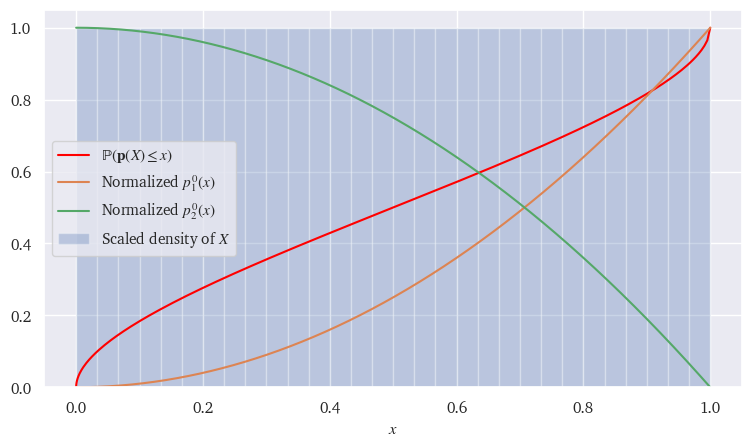

In [5]:
situation = str(5.2)
# MAYDO: get rid of this equi_distant stuff.
test = SimulateData(situation, 10**5, equi_distant=True)
test.visualize()

In [22]:
def opt_network(situation, n, viz=1, evals=42):
    # Parameters we definitely want: widths, learning rate
    # Probably: L1 penalty, dropout rate, number of layers, more Adam settings
    # TODO: make some parameters depend on n
    param_space = {}
    param_space['L'] = 2 + hp.randint('L-2', 4)
    param_space['lr'] = hp.uniform('lr', 0.001, 0.008)
    print(f"Searching for optimal {param_space.keys()} in {evals} attempts.")
    print(f"We're in situation {situation} with {n} samples.")

    val = SimulateData(situation, 10**4, equi_distant=True)
    def obj(params):
        hw = [16 for _ in range(params['L'])]
        opt = optimizers.Adam(params['lr'])

        train = SimulateData(situation, n)  # there's no default seed
        model = initialize_model(train, hw)
        kn = KerasModelStuff(train, val, model)
        kn.train_network(opt=opt, stop=.0005)
        losses = kn.evaluate(val, visualize=False, loss_only=True)

        if viz > 0:
            print(f"KL {losses['KL']:.4f} and MSE {losses['MSE']:.4f} with parameters {params}")
        return losses['KL']

    filename = f"{situation}__{n}.hyperopt"
    try: 
        trials = pickle.load(open(filename, "rb"))
        if evals <= len(trials.trials):
            trials.vals
            losses = np.asarray(trials.losses(), dtype=float)
            best_i = np.argmin(losses)
            best_params = {key: values[best_i] for key, values in trials.vals.items()}
            print("Already did", len(trials.trials), ">", evals, "trials, returning", 
                  best_params, "and trials that obtained KL", losses[best_i])
            return best_params, trials
        print(f"Found {len(trials.trials)} trials, so doing {evals - len(trials.trials)}.")
    except:
        if evals == 0:
            raise ValueError(f'evals == 0 and no {filename} found.')
        print(f"{filename} not found, starting trials from scratch.")
        trials = Trials()

    tpe_best = fmin(fn=obj, space=param_space, algo=tpe.suggest, max_evals=evals, trials=trials)
    with open(filename, "wb") as f:
        pickle.dump(trials, f)

    return tpe_best, trials

def evaluate(situation, n, test, n_repeats=5, opt_evals=0):
    params, _ = opt_network(situation, n, evals=opt_evals) 
    # TODO: params_to_trained_network function
    hw = [16 for _ in range(params['L-2'] + 2)]
    opt = optimizers.Adam(params['lr'])
    model = initialize_model(test, hw)
    assert test.situation == situation

    val = SimulateData(situation, 10**4, equi_distant=True)
    for i in range(n_repeats):
        print(f"\n**Iter. {i + 1} of {n} training samples in situation {situation}.**")
        train = SimulateData(situation, n)
        kn = KerasModelStuff(train, val, model)
        kn.train_network(opt=opt)
        results = kn.evaluate(test)
        print(f"KL: {results['KL']:.5f}, MSE: {results['MSE']:.5f}")
        # TODO: that quantile stuff from the old .py

Searching for optimal dict_keys(['L-2', 'lr']) in 60 attempts.
We're in situation 5.2 with 512 samples.
Already did 60 > 60 trials, returning {'L-2': 0, 'lr': 0.004383696258800031} and trials that obtained KL 0.007976947352290154

**Iter. 1 of a [16, 16] network on 512 training 5.2 samples.**


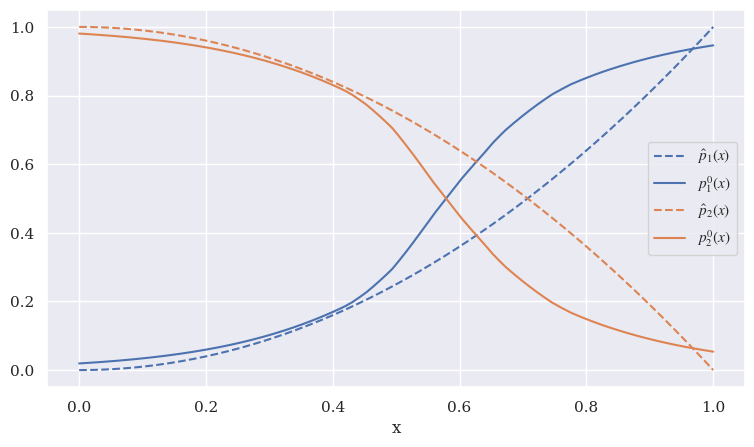

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


KL: 0.04393, MSE: 0.01597

**Iter. 2 of a [16, 16] network on 512 training 5.2 samples.**


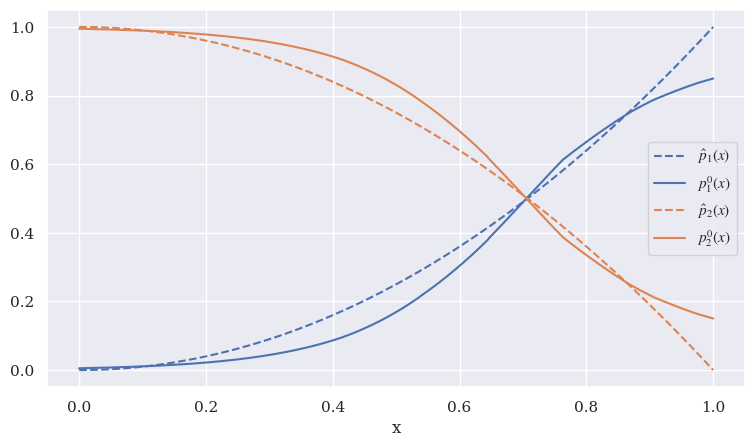

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


KL: 0.01270, MSE: 0.00267


In [25]:
evaluate(situation, 512, test, n_repeats=2, opt_evals=60)

### Temporarily moved out of the way

In [ ]:
def unif_rejection_sampling(p, n=10_000, seed=1):
    # Rejection sampling from p; proposal is unif[0, 1].
    # MAYDO: faster sampling method.
    np.random.seed(seed)
    q_pdf = ss.uniform().pdf
    q_sample = np.random.uniform

    grid = np.linspace(0, 1, 1000)
    m = max(p(grid)) * 1.3  # should divide by q_pdf(grid) but that's always 1.
    # The 1.3 factor is just to be sure m * q > p. Proportion accepted ~ 1/m.

    X = []
    while len(X) < n:
        z = q_sample()
        if np.random.uniform(0, m * q_pdf(z)) <= p(z):
            X.append(z)
    return np.array(X)


In sample_and_funcs:
    elif situation == "2":
        desc = f"Situation 2: sampling {n} X_i ~ 2D uniforms. f1(X) = sum(X) / 2. K = 2."
        X1 = np.random.uniform(size=n)
        X2 = np.random.uniform(size=n)
        X = np.column_stack([X1, X2])
        def f1(X): return (X[:, 0] + X[:, 1]) / 2
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]
    elif situation == "3":
        desc = f"Situation 3: sampling {n} X_i ~ a mixture of normals. K = 2."
        mu = [.4, .8]
        sigma = [.5, .1]
        pY = [.5, .5]

        def p(x):
            return sum([ss.norm(mu[i], sigma[i]).pdf(x) * pY[i] for i in range(len(mu))])

        X = unif_rejection_sampling(p, n, seed)
        funcs = [ss.norm(mu[i], sigma[i]).pdf for i in range(len(mu))]
    elif situation == "4":
        desc = f"Situation 4: sampling {n} X_i ~ 1D uniform. f1(X)=f2(X). K = 2."
        X = np.random.uniform(size=n)
        def f1(X): return (1 + X) / 3
        def f2(X): return f1(X)
        funcs = [f1, f2]
        elif "6." in situation:
        # TODO: handle above?
        K_str = situation.split('.')[1]
        if K_str != "":
            K = int(K_str)
        else:
            K = 3
            print("K not specified, just setting it to 3.")
        desc = f"Situation 6: sampling {n} X_i ~ 1D uniform. f_k(X) = a normal. K = {K}."
        X = np.random.uniform(size=n)
        funcs = []
        for k in range(K):
            funcs.append(lambda x, k=k: ss.norm(k / K, 0.5 / K).pdf(x))
    elif situation == "7":
        desc = f"Situation 7: sampling {n} X_i ~ 1D uniform. f1(X) = TODO. K = 2."
        X = np.random.uniform(size=n)
        beta = 4
        def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]
    elif situation == "8":
        desc = f"Situation 8: sampling {n} X_i ~ a mixture of uniforms. K = 2."
        a = [0.05, .55]
        b = [.45, .95]
        pY = [.5, .5]

        def p(x):
            return sum([ss.uniform(a[i], b[i]).pdf(x) * pY[i] for i in range(len(pY))])

        X = unif_rejection_sampling(p, n, seed)
        def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * 3))
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]
    elif situation == "9":
        desc = "Taylor sin(uniform[0, pi / 2])."
        X = np.random.uniform(high=np.math.pi/2, size=n)
        m = 10  # can't be high, factorial gets too large
        def f1(X): return 1e-10 + sum(
            [(-1) ** (i+1) * X ** (2*i-1) / np.math.factorial(2*i-1) for i in range(1, m)])

        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]

In visualize:
    elif X.ndim == 2:
        plt.plot(t_space, p_X_smaller, color='red',
                 label='$\mathrm{\mathbb{P}}(\mathbf{p}(\mathbf{X}) \leq x)$')
        x, _, p = plt.hist(X, bins=30, density=True, alpha=.3,
                           label=[f'Scaled density of $X_{j+1}$' for j in range(X.shape[1])])
        for j in range(X.ndim):
            for item in p[j]:
                item.set_height(item.get_height() / max(x[j]))

        plt.legend()
        plt.show()

        # Subset in case 2D:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        subset = np.random.choice(X.shape[0], 200)
        for i in range(Y_prob.shape[1]):
            ax.scatter(X[subset, 0], X[subset, 1], Y_prob[subset, i],
                       label=f'$p^0_{i+1}(\mathbf{{x}})$')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        plt.show()
        plt.show()

In visualize_tf:
    elif X_test.shape[1] == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        n, k = Y_prob_test.shape
        subset = np.random.choice(n, 200)
        step = int(n / 200)
        subset = list(np.argsort(X_test[:, 0]))[::step]
        # MAYDO: seperate plots for both classes
        for i in range(k):
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_test_pred[subset, i],
                       label=f'$\hat{{p}}_{i+1}(\mathbf{{x}})$')
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_prob_test[subset, i],
                       label=f'$p^0_{i+1}(\mathbf{{x}})$', marker='^')

        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        plt.show()
        plt.show()
    else:
        print("Not visualizing since X.ndim > 2")